## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*





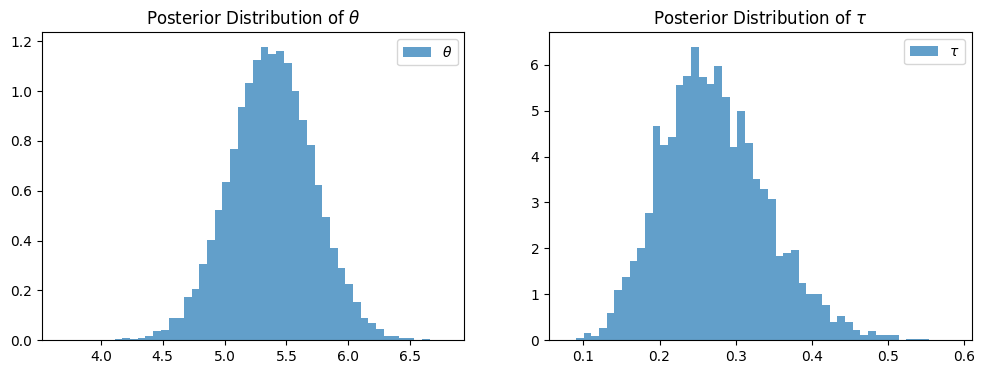

In [1]:
# Q1
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Initialization #
n = 30
m = 5
s = 2
theta_0 = 5
tau_0 = 1
alpha = 2
lmbda = 2

# Data Generation #
x = stats.norm(loc = m, scale = s).rvs(size = n)
C, G = 2, 10000
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = x.mean()
tau[:, 0] = 1 / s**2

# Metropolis within Gibbs #
for c in range(C):
    for g in range(1, G):
        def tau_target(tau_):
            if tau_ <= 0:
                return 0 # non-negative required
            likelihood = np.prod(stats.norm(loc = theta[c, g - 1],
                                            scale = (1 / tau_) ** 0.5).pdf(x))
            prior = stats.gamma(a = alpha / 2, scale = 2 / lmbda).pdf(tau_)
            return likelihood * prior

        tau_proposal = stats.gamma(a = 5, scale = 0.1)
        tau_tilde = tau_proposal.rvs()

        mh_ratio = (tau_target(tau_tilde) / tau_target(tau[c, g - 1])) * \
                   (tau_proposal.pdf(tau[c, g - 1])/tau_proposal.pdf(tau_tilde))

        acceptance_probability = min(1, mh_ratio)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c, g] = tau_tilde
        else:
            tau[c, g] = tau[c, g - 1]

        # Theta #
        theta_mean = (tau[c, g] * np.sum(x) +
                      tau_0 * theta_0) / (n * tau[c, g] + tau_0)
        theta_sd = np.sqrt(1 / (n * tau[c, g] + tau_0))
        theta[c, g] = stats.norm(loc = theta_mean, scale = theta_sd).rvs()

# Plots #
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(theta[:, 1000:].flatten(), bins = 50,
           density = True, alpha = 0.7, label = r"$\theta$")
ax[1].hist(tau[:, 1000:].flatten(), bins=50,
           density = True, alpha = 0.7, label = r"$\tau$")
ax[0].set_title(r"Posterior Distribution of $\theta$")
ax[1].set_title(r"Posterior Distribution of $\tau$")
ax[0].legend()
ax[1].legend()
plt.show()


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

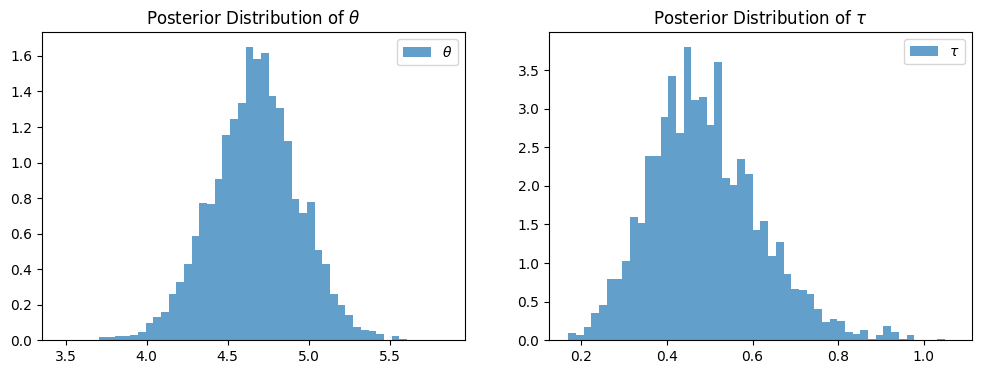

In [4]:
# Q2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Initialize #
n = 30
m = 5
s = 2
theta_0 = 5
tau_0 = 1
alpha = 2
lmbda = 2
lambda_theta = 1

# Data Generation #
x = stats.norm(loc = m, scale = s).rvs(size = n)
C, G = 2, 10000
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = x.mean()
tau[:, 0] = 1 / s**2

# Metropolis within Gibbs #
for c in range(C):
    for g in range(1, G):
        tau_t_minus_1 = tau[c, g - 1]
        a, b = -tau_t_minus_1 / s, np.inf
        tau_tilde = stats.truncnorm(a = a, b = b, loc = tau_t_minus_1,
                                    scale = s).rvs()

        def tau_target(tau_):
            if tau_ <= 0:
                return 0  # non-negative required
            likelihood = np.prod(stats.norm(loc = theta[c, g - 1],
                                            scale = (1 / tau_) ** 0.5).pdf(x))
            prior = stats.gamma(a = alpha / 2, scale = 2 / lmbda).pdf(tau_)
            return likelihood * prior

        mh_ratio = tau_target(tau_tilde) / tau_target(tau_t_minus_1)
        acceptance_probability = min(1, mh_ratio)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c, g] = tau_tilde
        else:
            tau[c, g] = tau_t_minus_1

        theta_t_minus_1 = theta[c, g - 1]
        theta_tilde = stats.norm(loc = theta_t_minus_1, scale = 1).rvs()

        def theta_target(theta_):
            likelihood = np.prod(stats.norm(loc = theta_,
                                            scale = (1 / tau[c, g]) ** 0.5).pdf(x))
            prior = np.exp(-lambda_theta * abs(theta_))
            return likelihood * prior

        mh_ratio = theta_target(theta_tilde) / theta_target(theta_t_minus_1)
        acceptance_probability = min(1, mh_ratio)
        if stats.uniform().rvs() < acceptance_probability:
            theta[c, g] = theta_tilde
        else:
            theta[c, g] = theta_t_minus_1

# Plots #
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(theta[:, 1000:].flatten(), bins = 50, density = True,
           alpha = 0.7, label = r"$\theta$")
ax[1].hist(tau[:, 1000:].flatten(), bins = 50, density = True,
           alpha = 0.7, label = r"$\tau$")
ax[0].set_title(r"Posterior Distribution of $\theta$")
ax[1].set_title(r"Posterior Distribution of $\tau$")
ax[0].legend()
ax[1].legend()
plt.show()

### Q3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$

This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain.


## Q3 Answer

### Proposal Distribution:

$q\left(x^{(t)}|x^{(t-1)}\right)=\left(\frac12\right)^{1-x^{(t)}}\left(\frac12\right)^{x^{(t)}}$

We thus have the following:

$q(0|0)=\frac12, q(0|1)=\frac12, q(1|0)=\frac12, q(1|1)=\frac12$

Therefore, it can be seen that the proposal distribution is summetric. This will cancel in the Metropolis-Hastings ratio.

### Stationary Distribution

$p\left(x^{(t)}\right)=\left(\frac13\right)^{1-x^{(t)}}\left(\frac23\right)^{x^{(t)}}$

We thus have the following:

$p(0)=\frac13, p(1)=\frac23$

### Acceptance Probabilities

$P\left(x^{(t-1)}\to x^{(t)}\right)=\text{min}\left(1,\frac{p\left(x^{(t)}\right)}{p\left(x^{(t-1)}\right)}\right)$

$P(0\to1)=\text{min}\left(1,\frac{p(1)}{p(0)}\right)=\text{min}\left(1, \frac{\frac23}{\frac13}\right)=\text{min}(1, 2)=1$

$P(1\to0)=\text{min}\left(1,\frac{p(0)}{p(1)}\right)=\text{min}\left(1, \frac{\frac13}{\frac23}\right)=\text{min}(1, \frac12)=\frac12$

### Transition Kernel

Probability of Staying at 0:

$P\left(x^{(t)}=0\to x^{(t+1)}=0\right)=q(0|0)+q(1|0)(1-P(0\to1))=\frac12$

Probability of Staying at 1:

$P\left(x^{(t)}=1\to x^{(t+1)}=1\right)=q(1|1)+q(0|1)(1-P(1\to0))=\frac12+\left(\frac12\right)^2=\frac34$

Probability of transitioning from 0 to 1:

$P\left(x^{(t)}=0\to x^{(t+1)}=1\right)=q(1|0)P(0\to 1)=\frac12(1)=\frac12$

Probability of transitioning from 1 to 0:

$P\left(x^{(t)}=1\to x^{(t+1)}=0\right)=q(0|1)P(1\to 0)=\left(\frac12\right)^2=\frac14$

### Transition Matrix

$\begin{bmatrix}P(0\to0) & P(0\to 1)\\P(1\to 0) & P(1\to 1)\end{bmatrix}=\begin{bmatrix}0.5 & 0.5\\0.25 & 0.75\end{bmatrix}$







